In [1]:
#libraries 
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import linear_model, ensemble, model_selection, metrics, datasets
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay, r2_score,PredictionErrorDisplay, classification_report, confusion_matrix, roc_auc_score, mean_squared_error,PrecisionRecallDisplay, average_precision_score, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import plotly.express as px

import scipy.stats as stats
from scipy.stats import randint
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

import pickle
import csv
from collections import defaultdict

import os
if not os.path.exists("20250108_images"):
    os.mkdir("20250108_images") 

In [3]:
#data_download 
L= pd.read_csv("lip_forfinal.csv") #just the lipids 
Z= pd.DataFrame(pd.read_csv("CRvnoR_lip_forfinal.csv")) #clinical features
Z['response'] = Z['response'].replace('CR', 0).replace('NR', 1)

y = Z['response']
X = L

In [4]:
SEED = 42
##Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=SEED,stratify=y)



In [5]:
##Identify correlated features for pruning

corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert the correlation matrix to a distance matrix before performing hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))


##Name features that have not been pruned
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]
# selected_features_names_CSV=pd.DataFrame(selected_features_names) ##Save the feature list
# selected_features_names_CSV.to_csv("20250210_pruned_features.csv")

selected_features_names_CSV=open("20250210_pruned_features.csv", 'r')
file=csv.DictReader(selected_features_names_CSV)
pruned_features= []
for col in file:
    pruned_features.append(col['0'])

selected_features= X[pruned_features]
selected_features_names = selected_features.columns.tolist()


In [13]:
##Apply feature pruning; training and testing data
X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

##Oversample the undersampled group (NR) so that the numbers are equal to CR; in training set only 
smote = SMOTE( sampling_strategy = 1.0, random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(
    X_train_sel, y_train)

In [6]:
#Cross-validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)



In [7]:
#Model Parameters; Set up possible values of parameters to optimize over
param_rfc = { 
    'n_estimators': [50,100,150,200,250,300,350,400,450,500], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3,5,8,10,13,15,18,20], 
    'max_leaf_nodes': [3,5,8,10,13,15,18,20,25,30,35,40,45,50], 
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'ccp_alpha':[0, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
} 

param_lrm={
    'solvers' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l2','elasticnet', 'l1'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
}
param_rfc2 = { 

    'n_estimators': [50,100,150,200,250,300,350,400,450,500], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3,5,8,10,13,15,18,20], 
    'max_leaf_nodes': [3,5,8,10,13,15,18,20,25,30,35,40,45,50], 
    'warm_start': [True, False],
    'ccp_alpha':[0, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
} 
param_xgb={
    'max_depth': [3,5,8,10,13,15,18,20], 
    'learning_rate': [0, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035,0.05,0.06,0.07,0.08,0.09,0.1],
    'subsample':[0.5, 0.5],
    'n_estimators': [50,100,150,200,250,300,350,400,450,500], 
}

param_sgd={
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': [ 'log_loss'], # logistic regression
    'penalty': ['l2', 'elasticnet',],
    'n_jobs': [-1]
}

param_lrm2={
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l2','elasticnet'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
}
lrm = linear_model.LogisticRegression(random_state=0)
etc = ExtraTreesClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
sgd = SGDClassifier(random_state=0)
xgb_m = XGBClassifier(random_state=0)

In [ ]:
# parameter search and scoring
#random forest
rfc_1 = RandomizedSearchCV(estimator=rfc, param_distributions=param_rfc, cv=cv, refit=True, scoring= 'f1')
rfc_1.fit(X_resampled, y_resampled)
score_rfc1 = cross_val_score(rfc_1, X_resampled, y_resampled, cv=cv, scoring='f1')

#extra tree
rfc_2 = RandomizedSearchCV(estimator=etc, param_distributions=param_rfc, cv=cv, refit=True, scoring= 'f1')
rfc_2.fit(X_resampled, y_resampled)
score_rfc2 = cross_val_score(rfc_2, X_resampled, y_resampled, cv=cv, scoring='f1')

#gradient boosting
rfc_3 = RandomizedSearchCV(estimator=gbc, param_distributions=param_rfc2, cv=cv, refit=True, scoring= 'f1')
rfc_3.fit(X_resampled, y_resampled)
score_rfc3 = cross_val_score(rfc_3, X_resampled, y_resampled, cv=cv, scoring='f1')

#XGboost

xgb_1 = RandomizedSearchCV(estimator=xgb_m, param_distributions=param_xgb, cv=cv, refit=True, scoring= 'f1')
xgb_1.fit(X_resampled, y_resampled)
score_xgb1= cross_val_score(xgb_1, X_resampled, y_resampled, cv=cv, scoring='f1')

#SGD 
sgb_1 = GridSearchCV(estimator=sgd, param_grid=param_sgd, cv=cv, refit=True, scoring= 'f1')
sgb_1.fit(X_resampled, y_resampled)
score_sgb1= cross_val_score(sgb_1, X_resampled, y_resampled, cv=cv, scoring='f1')

#linear regression
lrm_1 = GridSearchCV(estimator=lrm, param_grid=param_lrm2, cv=cv, refit=True, scoring= 'f1')
lrm_1.fit(X_resampled, y_resampled)
score_lrm1 = cross_val_score(lrm_1, X_resampled, y_resampled, cv=cv, scoring='f1')

print("done")

##151 mins

In [ ]:
#Compare results to select best score 
bench = (score_rfc1.mean(), score_rfc2.mean(), score_rfc3.mean(), score_sgb1.mean(), score_xgb1.mean(), score_lrm1.mean())
print (bench)

# Last result: (0.9513920817369094, 0.9408264915161466, 0.9548108851557128, 0.8246809057766885, 0.9459128014077958, 0.9212748438888594)

(0.9513920817369094, 0.9408264915161466, 0.9548108851557128, 0.8246809057766885, 0.9459128014077958, 0.9212748438888594)


In [ ]:
#identify the best model
rfc_3.best_estimator_

# Last result:
# GradientBoostingClassifier(ccp_alpha=0, max_depth=10, max_features='log2',
#                            max_leaf_nodes=35, n_estimators=400, random_state=0,
#                            warm_start=True)

GradientBoostingClassifier(ccp_alpha=0, max_depth=10, max_features='log2',
                           max_leaf_nodes=35, n_estimators=400, random_state=0,
                           warm_start=True)

In [86]:
#build best model 
# model = GradientBoostingClassifier(ccp_alpha=0, max_depth=10, max_features='log2',
#                            max_leaf_nodes=35, n_estimators=400, random_state=0,
#                            warm_start=True)

## OR load model 

# load the lipid model from pickle file
model_pkl_file = "20250324_Lipid_GBC_.pkl"  
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

# evaluate model 
y_predict = model.predict(X_test_sel)

# check results
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        36
           1       0.67      0.91      0.77        11

    accuracy                           0.87        47
   macro avg       0.82      0.89      0.84        47
weighted avg       0.90      0.87      0.88        47



In [16]:
#Fit and evaluate best model 
model.fit(X_resampled, y_resampled)

train_result = permutation_importance(
   model , X_resampled, y_resampled, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    model, X_test_sel, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [66]:
##Feature importance for the final model

feature_names = X_resampled.columns

coefs = pd.DataFrame(
    model.feature_importances_,
    columns=["Coefficients"],
    index=feature_names,
)
features=[]
ft_importances = pd.Series(model.feature_importances_, index = X_resampled.columns.values).sort_values(ascending=False)

for i,v in enumerate(ft_importances):
    features.append ('Feature: %0d, Score: %.5f' %(i,v))
xx3=pd.DataFrame(features)

fig2= px.bar(ft_importances.head(100))
fig2.show()

#Feature importance permutation
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# ##Important features from test importances
# ax2 = test_importances.plot.box(vert=False, whis=10)
# ax2.set_title("Permutation Importances (test set)")

# fig2.write_image("20250210_images/Important_Features_20250214.png")


In [ ]:

classifier_output_for_survival= pd.DataFrame(model.predict_proba(X[selected_features_names]))

# ##Save the data

# train_importances.to_csv ('20250210_lip_features_train_.csv', index=False)
# coefs.to_csv('20250210_lip_coefs_.csv',index=False)
# test_importances.to_csv('20250210_lip_features_test_2.csv', index=False)
# ft_importances.to_csv('20250210_lip_ft_importance_.csv')
# classifier_output_for_survival.to_csv('20250210_classification_output_for_survival_ALL.csv')
# X_train.to_csv("Training_20250210.csv")
# X_test.to_csv("Testing_20250210.csv")


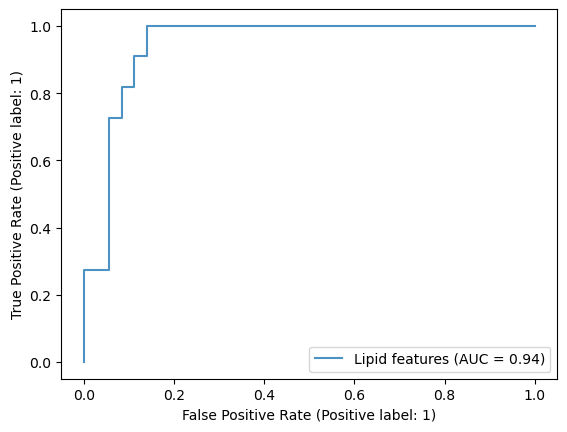

In [13]:
##ROC
fig, ax2 = plt.subplots()
ax2 = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test_sel, y_test, ax=ax2, alpha=0.8, name="Lipid features")
plt.show()
# fig.savefig("20250108_images/ROC_test_train.png")

In [ ]:
# # save the lipid classification model as a pickle file

# model_pkl_file = "20250324_Lipid_GBC_.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(model, file)

In [8]:
##lipids with clinical features 
#data_download 
LC= pd.read_csv("lip_plusclin_forfinal.csv") #Lipids with clinical features

yA = Z['response']
XA = LC

In [9]:
##Train/Test
XA_train, XA_test, yA_train, yA_test = train_test_split(XA, yA,  test_size=0.2, random_state=SEED,stratify=yA)


In [11]:
##use pruned lipid list with clinical features 

selected_features_namesA_CSV=open("20250210_pruned_features_clin_lip.csv", 'r')
fileA=csv.DictReader(selected_features_namesA_CSV)
pruned_featuresA= []
for col in fileA:
    pruned_featuresA.append(col['0'])

selected_featuresA= XA[pruned_featuresA]
selected_features_namesA = selected_featuresA.columns.tolist()


In [14]:
##Apply feature pruning; training and testing data
XA_train_sel = XA_train[selected_features_namesA]
XA_test_sel = XA_test[selected_features_namesA]

##Oversample the undersampled group (NR) so that the numbers are equal to CR; in training set only 
XA_resampled, yA_resampled = smote.fit_resample(
    XA_train_sel, yA_train)

In [16]:
# parameter search and scoring
#random forest
rfc_1A = RandomizedSearchCV(estimator=rfc, param_distributions=param_rfc, cv=cv, refit=True, scoring= 'f1')
rfc_1A.fit(XA_resampled, yA_resampled)
score_rfc1A = cross_val_score(rfc_1A, XA_resampled, yA_resampled, cv=cv, scoring='f1')

#extra tree
rfc_2A = RandomizedSearchCV(estimator=etc, param_distributions=param_rfc, cv=cv, refit=True, scoring= 'f1')
rfc_2A.fit(XA_resampled, yA_resampled)
score_rfc2A = cross_val_score(rfc_2A, XA_resampled, yA_resampled, cv=cv, scoring='f1')

#gradient boosting
rfc_3A = RandomizedSearchCV(estimator=gbc, param_distributions=param_rfc2, cv=cv, refit=True, scoring= 'f1')
rfc_3A.fit(XA_resampled, yA_resampled)
score_rfc3A = cross_val_score(rfc_3A, XA_resampled, yA_resampled, cv=cv, scoring='f1')

# #XGboost
xgb_1A = RandomizedSearchCV(estimator=xgb_m, param_distributions=param_xgb, cv=cv, refit=True, scoring= 'f1')
xgb_1A.fit(XA_resampled, yA_resampled)
score_xgb1A= cross_val_score(xgb_1A, XA_resampled, yA_resampled, cv=cv, scoring='f1')

##SGB
sgb_1A = GridSearchCV(estimator=sgd, param_grid=param_sgd, cv=cv, refit=True, scoring= 'f1')
sgb_1A.fit(XA_resampled, yA_resampled)
score_sgb1A= cross_val_score(sgb_1A, XA_resampled, yA_resampled, cv=cv, scoring='f1')

# #linear regression
lrm_1A = GridSearchCV(estimator=lrm, param_grid=param_lrm2, cv=cv, refit=True, scoring= 'f1')
lrm_1A.fit(XA_resampled, yA_resampled)
score_lrm1A = cross_val_score(lrm_1A, XA_resampled, yA_resampled, cv=cv, scoring='f1')
##117 mins

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\crobrien\AppData

In [18]:
bench1A = (score_rfc1A.mean(),score_rfc2A.mean(),score_rfc3A.mean(),score_lrm1A.mean(),score_xgb1A.mean(),score_sgb1A.mean())

print(bench1A)
##Last result(0.9442492245940521, 0.9513920817369094, 0.9340549169859514, 0.9417971173143587, 0.9560277439365314)

(0.9513665389527459, 0.9449553001277138, 0.9425031928480203, 0.9212748438888594, 0.9489235540959677, 0.8246809057766885)


In [ ]:
rfc_1A.best_estimator_

# Last result: 
# RandomForestClassifier(bootstrap=False, ccp_alpha=0.02, max_depth=15,
#                        max_features='log2', max_leaf_nodes=15, n_estimators=400,
#                        random_state=0)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.02, max_depth=15,
                       max_features='log2', max_leaf_nodes=15, n_estimators=400,
                       random_state=0)

In [28]:
# model1A= RandomForestClassifier(bootstrap=False, ccp_alpha=0.02, max_depth=15,
#                        max_features='log2', max_leaf_nodes=15, n_estimators=400,
#                        random_state=0)
# model1A.fit(XA_resampled, yA_resampled)

## OR load model 

# load the lipid model from pickle file
modelA_pkl_file = "20250324_Lipid_plusClin_RFC__.pkl"  
with open(modelA_pkl_file, 'rb') as file:  
    model1A = pickle.load(file)

# evaluate model 
yA_predict = model1A.predict(XA_test_sel)

# check results
print(classification_report(yA_test, yA_predict))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        36
           1       0.67      0.91      0.77        11

    accuracy                           0.87        47
   macro avg       0.82      0.89      0.84        47
weighted avg       0.90      0.87      0.88        47



In [25]:
train_result1A = permutation_importance(
    model1A, XA_resampled, yA_resampled, n_repeats=30, random_state=SEED, n_jobs=2
)
test_results1A = permutation_importance(
    model1A,XA_test_sel, yA_test, n_repeats=30, random_state=SEED, n_jobs=2
)
sorted_importances_idx1A = train_result1A.importances_mean.argsort()


In [31]:
##Feature importance for the final model

feature_names = XA_resampled.columns

coefs = pd.DataFrame(
    model1A.feature_importances_,
    columns=["Coefficients"],
    index=feature_names,
)
features=[]
ft_importances = pd.Series(model1A.feature_importances_, index = XA_resampled.columns.values).sort_values(ascending=False)

for i,v in enumerate(ft_importances):
    features.append ('Feature: %0d, Score: %.5f' %(i,v))
xx3=pd.DataFrame(features)

fig2= px.bar(ft_importances.head(100))
fig2.show()

# fig2.write_image("20250108_images/Important_Features_lip_plusclin.png")

In [ ]:
##Save the data


# coefs.to_csv('20250324_lipplusclin_coefs_.csv',index=False)
# ft_importances.to_csv('20250324_lipplusclin_ft_importance_.csv')

# classifier_output_for_survivalA= pd.DataFrame(model1A.predict_proba(XA_test_sel))
# classifier_output_for_survivalA.to_csv('20250324_classification_output_for_survival_lipplusclin.csv')

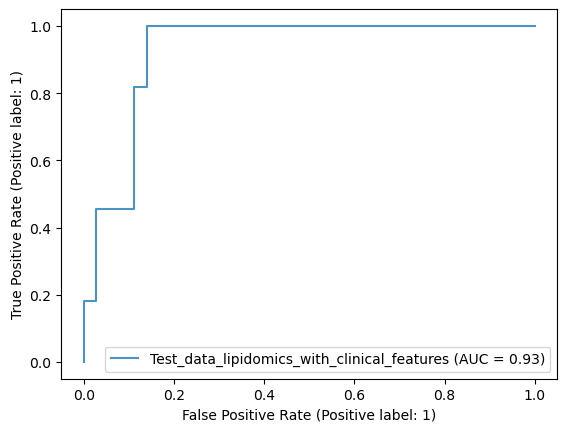

In [26]:
fig, ax2 = plt.subplots()
ax2 = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model1A, XA_test_sel, yA_test, ax=ax2, alpha=0.8, name='Test_data_lipidomics_with_clinical_features')
plt.show()
# fig.savefig("20250108_images/ROC__lip_plusClin.png")

In [ ]:
# # save the lipid-clinical classification model as a pickle file

# model_pkl_file = "20250324_Lipid_plusClin_RFC__.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(model1A, file)

In [38]:
##Clinical data based model 
C= pd.read_csv("CRvnoR_standpred_forfinal_.csv") ##Clinical paramaters 
Z2= pd.DataFrame(pd.read_csv("CRvnoR_lip_forfinal.csv")) #clinical features

Z2['response'] = Z2['response'].replace('CR', 0).replace('NR', 1)
y2 = Z2['response']
X2 = C

In [39]:
##Train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,  test_size=0.2, random_state=SEED, stratify=y2)


X_resampled2, y_resampled2 = smote.fit_resample(
    X_train2, y_train2)


In [ ]:
rfc_7 = RandomizedSearchCV(estimator=rfc, param_distributions=param_rfc, cv=cv, refit=True, scoring='f1')
rfc_7.fit(X_resampled2, y_resampled2,)
score_rfc7 = cross_val_score(rfc_7, X_resampled2, y_resampled2, cv=cv, scoring='f1')

rfc_8 = RandomizedSearchCV(estimator=etc, param_distributions=param_rfc, cv=cv, refit=True, scoring='f1')
rfc_8.fit(X_resampled2, y_resampled2,)
score_rfc8 = cross_val_score(rfc_8, X_resampled2, y_resampled2, cv=cv, scoring='f1')

rfc_9 = RandomizedSearchCV(estimator=gbc, param_distributions=param_rfc2, cv=cv, refit=True, scoring='f1')
rfc_9.fit(X_resampled2, y_resampled2)
score_rfc9 = cross_val_score(rfc_9, X_resampled2, y_resampled2, cv=cv, scoring='f1')

##SGB
sgb_2 = GridSearchCV(estimator=sgd, param_grid=param_sgd, cv=cv, refit=True, scoring= 'f1')
sgb_2.fit(X_resampled2, y_resampled2)
score_sgb2= cross_val_score(sgb_2, XA_resampled, yA_resampled, cv=cv, scoring='f1')

##LRM
param_lrm4={
    'solver' : ['newton-cg', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l2','elasticnet'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
}
lrm_2 = GridSearchCV(estimator=lrm, param_grid=param_lrm4, cv=cv, refit=True, scoring='f1')
lrm_2.fit(X_resampled2, y_resampled2)
score_lrm2 = cross_val_score(lrm_2, X_resampled2, y_resampled2, cv=cv, scoring='f1')

print("done")
##15 mins

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: Conver

done


c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: Conver

In [74]:
bench2 = (score_lrm2.mean(),score_rfc7.mean(),score_rfc8.mean(),score_rfc9.mean(),  score_sgb2.mean(),score_lrm2.mean())

print(bench2)

# Last results (0.6763013586001202, 0.7037603704823819, 0.7412842566493683, 0.7018500540677961)

(0.6763013586001202, 0.7062899776768946, 0.7427227059485124, 0.7037178589927603, 0.8246809057766885, 0.6763013586001202)


In [75]:
sgb_2.best_estimator_

# Last result ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.005, max_depth=15,
                    #  max_features=None, max_leaf_nodes=15, n_estimators=400,
                    #  random_state=0)

SGDClassifier(alpha=100.0, loss='log_loss', n_jobs=-1, random_state=0)

In [82]:
# model2 = sgb_2.best_estimator_
# model2.fit(X_resampled2, y_resampled2)


## OR load model 

# # load the lipid model from pickle file
model2_pkl_file = "20250324_CLIN_SGD_.pkl"  
with open(model2_pkl_file, 'rb') as file2:  
    model2 = pickle.load(file2)

# evaluate model 
y2_predict = model2.predict(X_test2)

# check results
print(classification_report(y_test2, y2_predict))

              precision    recall  f1-score   support

           0       0.84      0.44      0.58        36
           1       0.29      0.73      0.41        11

    accuracy                           0.51        47
   macro avg       0.56      0.59      0.50        47
weighted avg       0.71      0.51      0.54        47



In [77]:
train_result2 = permutation_importance(
    model2, X_resampled2, y_resampled2, n_repeats=30, random_state=SEED, n_jobs=2
)
test_results2 = permutation_importance(
    model2,X_test2, y_test2, n_repeats=30, random_state=SEED, n_jobs=2
)
sorted_importances_idx2 = train_result2.importances_mean.argsort()

In [78]:
# feature_names = X_train2.columns

# coefs2 = pd.DataFrame(
#     model2.feature_importances_,
#     columns=["Coefficients"],
#     index=feature_names,
# )
# features2=[]
# ft_importances2 = pd.Series(model2.feature_importances_, index = X_train2.columns.values).sort_values(ascending=False)

# for i,v in enumerate(ft_importances2):
#     features2.append ('Feature: %0d, Score: %.5f' %(i,v))
# xx2=pd.DataFrame(features2)

# fig2= px.bar(ft_importances2.head(100))
# fig2.show()

# train_importances2 = pd.DataFrame(
#     train_result2.importances[sorted_importances_idx2].T,
#     columns=X_train2.columns[sorted_importances_idx2],
# )
# test_importances2 = pd.DataFrame(
#     test_results2.importances[sorted_importances_idx2].T,
#     columns=X_train2.columns[sorted_importances_idx2],
# )

# fig2.write_image("20250108_images/Important_Features_clin.png")

In [86]:
# train_importances2.to_csv ('20250108_clin_features_train_.csv', index=False)
# coefs2.to_csv('20250108_clin_coefs_.csv',index=False)
# test_importances2.to_csv('20250108_clin_features_test_2.csv', index=False)
# ft_importances2.to_csv('20250108_clin_ft_importance_2.csv')


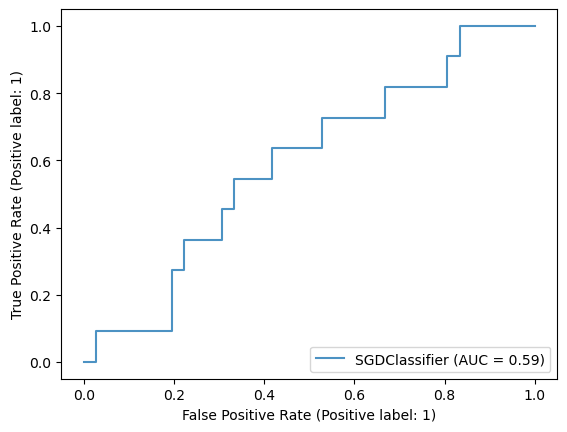

In [79]:
#ROC for pipelines
ax3 = plt.gca()
rfc_disp2 = RocCurveDisplay.from_estimator(model2, X_test2, y_test2, ax=ax3, alpha=0.8)


In [ ]:
# # save the clinical classification model as a pickle file
# model2_pkl_file = "20250324_CLIN_SGD_.pkl"  

# with open(model2_pkl_file, 'wb') as file2:  
#     pickle.dump(model2, file2)

In [35]:
M= pd.read_csv("CRvnoR_met_forfinal_.csv") #metabolites
Z3= pd.DataFrame(pd.read_csv("CRvnoR_met_forfinal.csv")) #clinical features

Z3['response'] = Z3['response'].replace('CR', 0).replace('NR', 1)
y3 = Z3['response']
X3 = M

In [36]:
##Train/test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3,  test_size=(0.2), random_state=SEED,stratify=y3)


In [ ]:
corr3 = spearmanr(X3).correlation
# Ensure the correlation matrix is symmetric
corr3 = (corr3 + corr3.T) / 2
np.fill_diagonal(corr3, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix3 = 1 - np.abs(corr3)
dist_linkage3 = hierarchy.ward(squareform(distance_matrix3))
from collections import defaultdict

cluster_ids3 = hierarchy.fcluster(dist_linkage3, 1, criterion="distance")
cluster_id_to_feature_ids3 = defaultdict(list)
for idx3, cluster_id3 in enumerate(cluster_ids3):
    cluster_id_to_feature_ids3[cluster_id3].append(idx3)
selected_features3 = [v[0] for v in cluster_id_to_feature_ids3.values()]
selected_features_names3 = X3.columns[selected_features3]

# selected_features_names_CSV3=pd.DataFrame(selected_features_names3) ##Save the feature list
# selected_features_names_CSV3.to_csv("20250324_pruned_features_met.csv")

selected_features_names_CSV3=open("20250324_pruned_features_met.csv", 'r')
file3=csv.DictReader(selected_features_names_CSV3)
pruned_features3= []
for col in file3:
    pruned_features3.append(col['0'])

selected_features3= X3[pruned_features3]
selected_features_names3 = selected_features3.columns.tolist()

In [45]:
X_train_sel3 = X_train3[selected_features_names3]
X_test_sel3 = X_test3[selected_features_names3]

X_resampled3, y_resampled3 = smote.fit_resample(
    X_train_sel3, y_train3)

In [46]:
# parameter search and scoring
rfc_10 = RandomizedSearchCV(estimator=rfc, param_distributions=param_rfc, cv=cv, refit=True, scoring='f1')
rfc_10.fit(X_resampled3, y_resampled3)
score_rfc10 = cross_val_score(rfc_10, X_resampled3, y_resampled3, cv=cv, scoring='f1')


rfc_20 = RandomizedSearchCV(estimator=etc, param_distributions=param_rfc, cv=cv, refit=True, scoring='f1')
rfc_20.fit(X_resampled3, y_resampled3)
score_rfc20 = cross_val_score(rfc_20, X_resampled3, y_resampled3, cv=cv, scoring='f1')


rfc_30 = RandomizedSearchCV(estimator=gbc, param_distributions=param_rfc2, cv=cv, refit=True, scoring='f1')
rfc_30.fit(X_resampled3, y_resampled3)
score_rfc30 = cross_val_score(rfc_30, X_resampled3, y_resampled3, cv=cv, scoring='f1')


xgb_m = XGBClassifier(random_state=0)
xgb_10 = RandomizedSearchCV(estimator=xgb_m, param_distributions=param_xgb, cv=cv, refit=True, scoring='f1')
xgb_10.fit(X_resampled3, y_resampled3)
score_xgb10= cross_val_score(xgb_10, X_resampled3, y_resampled3, cv=cv, scoring='f1')


sgb_10 = GridSearchCV(estimator=sgd, param_grid=param_sgd, cv=cv, refit=True, scoring='f1')
sgb_10.fit(X_resampled3, y_resampled3)
score_sgb10= cross_val_score(sgb_10, X_resampled3, y_resampled3, cv=cv, scoring='f1')


lrm_10 = GridSearchCV(estimator=lrm, param_grid=param_lrm2, cv=cv, refit=True, scoring='f1')
lrm_10.fit(X_resampled3, y_resampled3)
score_lrm10 = cross_val_score(lrm_10, X_resampled3, y_resampled3, cv=cv, scoring='f1')
print("done")

##37 mins

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\si

done


c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning:

The line search algorithm did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning:

The line search algorithm did not converge

c:\Users\crobrien\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



In [49]:
bench3 = (score_rfc10.mean(), score_rfc20.mean(), score_rfc30.mean(), score_sgb10.mean(), score_xgb10.mean(), score_sgb10.mean(), score_lrm10.mean())
print (bench3)

##Last results(0.8193752023117986, 0.8616591310473402, 0.7934412869090288, 0.4618696485968181, 0.8360691111817363, 0.720264109659549)

(0.8420600196573499, 0.8546011882691527, 0.8325736083222178, 0.3735266108831389, 0.8051256326172899, 0.3735266108831389, 0.7336581969416656)


In [ ]:
##paramater tuning 
rfc_20.best_estimator_

##Results ExtraTreesClassifier(ccp_alpha=0.0025, max_depth=10, max_features=None,
                    #  max_leaf_nodes=35, random_state=0)

ExtraTreesClassifier(ccp_alpha=0.0025, max_depth=10, max_features=None,
                     max_leaf_nodes=35, random_state=0)

In [84]:
# model3=ExtraTreesClassifier(ccp_alpha=0.0025, max_depth=10, max_features=None,
#                      max_leaf_nodes=35, random_state=0)
# model3.fit(X_resampled3, y_resampled3)

# # load model from pickle file
model3_pkl_file = "20250324_METABOLITE_ETC.pkl"  

with open(model3_pkl_file, 'rb') as file3:  
    model3 = pickle.load(file3)

# evaluate model 
y_predict3= model3.predict(X_test_sel3)

# check results
print(classification_report(y_test3, y_predict3))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72        36
           1       0.21      0.27      0.24        11

    accuracy                           0.60        47
   macro avg       0.49      0.48      0.48        47
weighted avg       0.63      0.60      0.61        47



In [52]:

train_result3 = permutation_importance(
     model3, X_resampled3, y_resampled3, n_repeats=30, random_state=SEED, n_jobs=2
)
test_results3 = permutation_importance(
    model3,X_test_sel3, y_test3, n_repeats=30, random_state=SEED, n_jobs=2
)
sorted_importances_idx3 = train_result3.importances_mean.argsort()

In [53]:
feature_names3 = X_resampled3.columns

coefs3 = pd.DataFrame(
    model3.feature_importances_,
    columns=["Coefficients"],
    index=feature_names3,
)
features3=[]
ft_importances3 = pd.Series(model3.feature_importances_, index = X_train_sel3.columns.values).sort_values(ascending=False)

for i,v in enumerate(ft_importances3):
    features3.append ('Feature: %0d, Score: %.5f' %(i,v))
xx3=pd.DataFrame(features3)

fig2= px.bar(ft_importances3.head(100))
fig2.show()

train_importances3 = pd.DataFrame(
    train_result3.importances[sorted_importances_idx3].T,
    columns=X3.columns[sorted_importances_idx3],
)
test_importances3 = pd.DataFrame(
    test_results3.importances[sorted_importances_idx3].T,
    columns=X3.columns[sorted_importances_idx3],
)


# fig2.write_image("20250108_images/Important_Features_met.png")

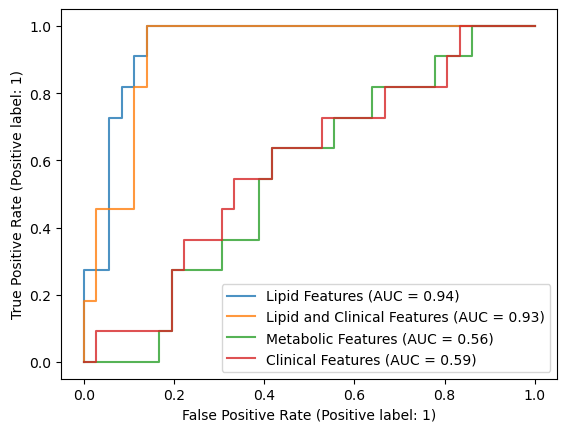

In [ ]:
#ROC for pipelines
fig7, ax3 = plt.subplots()
ax3 = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test_sel, y_test, ax=ax3, alpha=0.8,name='Lipid Features')
rfc_disp2 = RocCurveDisplay.from_estimator(model1A, XA_test_sel, yA_test, ax=ax3, alpha=0.8, name='Lipid and Clinical Features')
rfc_disp3 = RocCurveDisplay.from_estimator(model3, X_test_sel3, y_test3, ax=ax3, alpha=0.8, name='Metabolic Features')
rfc_disp2 = RocCurveDisplay.from_estimator(model2, X_test2, y_test2, ax=ax3, alpha=0.8, name='Clinical Features')

# fig7.savefig("20250108_images/ROC_lip_met_clin_lipplusclin.svg")


In [ ]:
# save the metabolite classification model as a pickle file
# model3_pkl_file = "20250324_METABOLITE_ETC.pkl"  

# with open(model3_pkl_file, 'wb') as file3:  
#     pickle.dump(model3, file3)


In [55]:
# train_importances3.to_csv ('20250108_met_features_train_.csv', index=False)
# coefs3.to_csv('20250108_met_coefs_.csv',index=False)
# test_importances3.to_csv('20250108_met_features_test_2.csv', index=False)
# ft_importances3.to_csv('20250108_met_ft_importance_2.csv')